# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import datetime

def imread(path):
    from PIL import Image
    return np.array(Image.open(path))

def imresize(img, size):
    from PIL import Image
    return np.array(Image.fromarray(img).resize(size))

In [2]:
import imageio
from skimage.transform import resize
import random as rn
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

Method to set the random seed so that the results don't vary drastically.

In [3]:
def random_set_seeds():
    np.random.seed(30)
    rn.seed(30)
    tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
print(len(train_doc))
print(len(val_doc))
batch_size = 30

663
100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #create a list of image numbers you want to use for a particular video
    img_idx = list(range(0, 30, 3)) 
    # Assigning value to variables used in below code
    x, y, z = len(img_idx), image_x_shape, image_y_shape
    while True:
        t = np.random.permutation(folder_list)
        #num_batches = # calculate the number of batches
        num_total_folders = len(folder_list)
        num_batches = num_total_folders // batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
                                     
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    resizedImage = resize(image, (y, z),anti_aliasing=True)
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resizedImage = resizedImage / 255 
                    
                    #batch_data[folder,idx,:,:,0] = #normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = #normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (resizedImage[:, :, 0] - resizedImage[:, :, 0].mean()) / resizedImage[:, :, 0].std()
                    batch_data[folder,idx,:,:,1] = (resizedImage[:, :, 1] - resizedImage[:, :, 1].mean()) / resizedImage[:, :, 1].std()
                    batch_data[folder,idx,:,:,2] = (resizedImage[:, :, 2] - resizedImage[:, :, 2].mean()) / resizedImage[:, :, 2].std()
                 
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        missing_count = num_total_folders - (num_batches * batch_size)
        if missing_count != 0:
            batch_data = np.zeros((missing_count,x,y,z,3))
            batch_labels = np.zeros((missing_count,5)) 
                
            for folder in range(missing_count):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    resizedImage = resize(image, (y, z),anti_aliasing=True)
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    ### Normalize the data
                    resizedImage = resizedImage / 255 
                    ###

                    ### Standardise the Data
                    batch_data[folder,idx,:,:,0] = (resizedImage[:, :, 0] - resizedImage[:, :, 0].mean()) / resizedImage[:, :, 0].std() #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resizedImage[:, :, 1] - resizedImage[:, :, 1].mean()) / resizedImage[:, :, 1].std()
                    batch_data[folder,idx,:,:,2] = (resizedImage[:, :, 2] - resizedImage[:, :, 2].mean()) / resizedImage[:, :, 2].std()
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                         
        yield batch_data, batch_labels



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)
no_classes = 5
print ('# epochs =', no_classes)

# training sequences = 663
# validation sequences = 100
# epochs = 30
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Dense, Flatten, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers,regularizers
from tensorflow.keras.regularizers import l2
from sklearn.metrics import roc_auc_score

## MODEL 1: CONV2D and LTSM

In [8]:
image_x_shape = 100
image_y_shape = 100
num_epochs=30
batch_size = 30
random_set_seeds()

In [9]:
class Convolution2DWithLSTM():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        cnn_model = Sequential()
        cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_x_shape, 3)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        cnn_model.add(Dropout(0.50))
        
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        
        cnn_model.add(TimeDistributed(Flatten()))
        cnn_model.add(LSTM(64, return_sequences=False))
        cnn_model.add(Dropout(.2))
        cnn_model.add(Dense(5, activation='softmax'))
        return cnn_model

In [10]:
#pip install numpy==1.19.5

In [11]:
#pip install -U tensorflow

In [12]:
print(np.version)

<module 'numpy.version' from '/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/numpy/version.py'>


In [13]:
np.version.version

'1.22.3'

In [14]:
print(tf.__version__)

2.8.0


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [15]:
obj = Convolution2DWithLSTM()
model = obj.model(batch_size)
optimiser = optimizers.SGD()

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 100, 100, 32)  128      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 100, 100, 32)  0        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 49, 49, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 49, 49, 32)   128       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 49, 49, 32)   9

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 2,
                             verbose = 1, mode = "auto", cooldown = 0)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-19-e82077a6fcdf>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 5.2701 - accuracy: 0.2217Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-05-1103_33_13.120849/model-00001-5.27007-0.22172.h5
23/23 [==============================] - 195s 8s/step - loss: 5.2701 - accuracy: 0.2217 - val_loss: 5.1943 - val_accuracy: 0.2600 - lr: 0.0100
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 5.1596 - accuracy: 0.2670
Epoch 2: saving model to model_init_2022-05-1103_33_13.120849/model-00002-5.15962-0.26697.h5
23/23 [==============================] - 152s 7s/step - loss: 5.1596 - accuracy: 0.2670 - val_loss: 5.1388 - val_accuracy: 0.2800 - lr: 0.0100
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 5.0447 - accuracy: 0.3469
Epoch 3: saving model to model_init_2022-05-1103_33_13.120849/model-00003-5.04468-0.34691.h5
23/23 [==============================] - 147s 6s/st

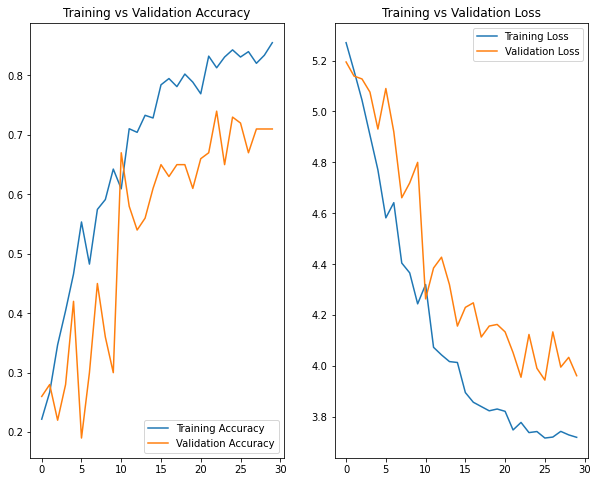

In [20]:
history = model_history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()


## Model 2: Conv2D with LSTM with increased batch size 

In [8]:
batch_size=60
num_epochs=30
image_x_shape = 100
image_y_shape = 100
random_set_seeds()

class Convolution2DWithLSTMParameterchange_A():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        cnn_model = Sequential()
        cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_x_shape, 3)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        cnn_model.add(Dropout(0.50))
        
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        
        cnn_model.add(TimeDistributed(Flatten()))
        cnn_model.add(LSTM(64, return_sequences=False))
        cnn_model.add(Dropout(.2))
        cnn_model.add(Dense(5, activation='softmax'))
        return cnn_model

In [9]:
obj = Convolution2DWithLSTMParameterchange_A()
model = obj.model(batch_size)
optimiser = optimizers.SGD()

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 100, 100, 32)  128      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 100, 100, 32)  0        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 49, 49, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 49, 49, 32)   128       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 49, 49, 32)   9

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 2,
                             verbose = 1, mode = "auto", cooldown = 0)
callbacks_list = [checkpoint, LR]

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [13]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-13-e82077a6fcdf>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 60
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 2.3884 - accuracy: 0.2187 Source path =  Project_data/val ; batch size = 60

Epoch 1: saving model to model_init_2022-05-1004_26_31.229991/model-00001-2.38840-0.21870.h5
12/12 [==============================] - 241s 20s/step - loss: 2.3884 - accuracy: 0.2187 - val_loss: 2.3276 - val_accuracy: 0.1700 - lr: 0.0100
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 2.3347 - accuracy: 0.2428 
Epoch 2: saving model to model_init_2022-05-1004_26_31.229991/model-00002-2.33473-0.24284.h5
12/12 [==============================] - 203s 17s/step - loss: 2.3347 - accuracy: 0.2428 - val_loss: 2.3185 - val_accuracy: 0.2500 - lr: 0.0100
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 2.2891 - accuracy: 0.3062 
Epoch 3: saving model to model_init_2022-05-1004_26_31.229991/model-00003-2.28913-0.30618.h5
12/12 [==============================] - 199s 

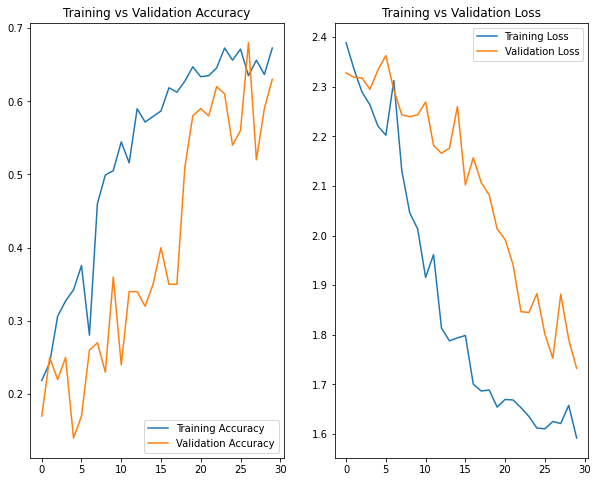

In [15]:
history = model_history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()


## Model 3: Conv2D with LSTM with different optimizer and regularizer and more epochs

In [8]:
batch_size=30
num_epochs=40
image_x_shape = 160
image_y_shape = 160
random_set_seeds()

class Convolution2DWithLSTMParameterchange_B():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        cnn_model = Sequential()
        cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_x_shape, 3)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        cnn_model.add(Dropout(0.50))
        
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        
        cnn_model.add(TimeDistributed(Flatten()))
        
        cnn_model.add(Dense(64, activation='relu'))
        cnn_model.add(LSTM(64, return_sequences=False))
        cnn_model.add(Dropout(.2))
        cnn_model.add(Dense(5, activation='softmax'))
        
        return cnn_model

In [9]:
obj = Convolution2DWithLSTMParameterchange_B()
model = obj.model(batch_size)
optimiser = optimizers.Adam()

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 160, 160, 32)  128      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 160, 160, 32)  0        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 79, 79, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 79, 79, 32)   128       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 79, 79, 32)   9

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 2,
                             verbose = 1, mode = "auto", cooldown = 0)
callbacks_list = [checkpoint, LR]

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [13]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-13-e82077a6fcdf>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 30
Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 4.0808 - accuracy: 0.2081 Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-05-1009_47_17.625664/model-00001-4.08082-0.20814.h5
23/23 [==============================] - 331s 14s/step - loss: 4.0808 - accuracy: 0.2081 - val_loss: 2.8591 - val_accuracy: 0.2300 - lr: 0.0010
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 2.3847 - accuracy: 0.2232 
Epoch 2: saving model to model_init_2022-05-1009_47_17.625664/model-00002-2.38473-0.22323.h5
23/23 [==============================] - 292s 13s/step - loss: 2.3847 - accuracy: 0.2232 - val_loss: 2.1115 - val_accuracy: 0.1700 - lr: 0.0010
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 1.9089 - accuracy: 0.2006 
Epoch 3: saving model to model_init_2022-05-1009_47_17.625664/model-00003-1.90887-0.20060.h5
23/23 [==============================] - 290s 

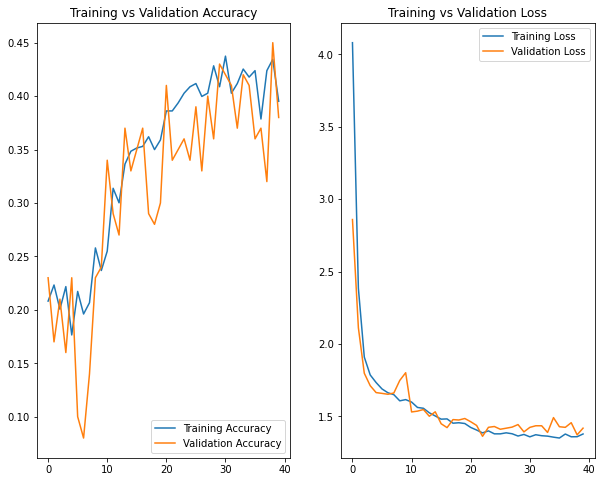

In [15]:
history = model_history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()


## Model 4: Conv3D with SGD

In [10]:
batch_size=30
num_epochs=30
image_x_shape = 100
image_y_shape = 100
random_set_seeds()

In [11]:
class convolution3D():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        model = Sequential()
      
        model.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, image_x_shape, image_y_shape, 3)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01)))
        
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2),data_format='channels_first'))
        model.add(BatchNormalization())
        
       
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
        return model

In [12]:
obj = convolution3D()
model = obj.model(batch_size)
optimiser = optimizers.SGD()

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 100, 100, 8)   656       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 50, 50, 8)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 5, 50, 50, 8)     32        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 50, 50, 16)     3472      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 25, 25, 16)    0         
 3D)                                                             
                                                      

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 2,
                             verbose = 1, mode = "auto", cooldown = 0)
callbacks_list = [checkpoint, LR]

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [16]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-16-e82077a6fcdf>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 4.1986 - accuracy: 0.1689Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-05-1013_27_23.908634/model-00001-4.19865-0.16893.h5
23/23 [==============================] - 180s 8s/step - loss: 4.1986 - accuracy: 0.1689 - val_loss: 3.8497 - val_accuracy: 0.2300 - lr: 0.0100
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 4.0755 - accuracy: 0.2142
Epoch 2: saving model to model_init_2022-05-1013_27_23.908634/model-00002-4.07552-0.21418.h5
23/23 [==============================] - 152s 7s/step - loss: 4.0755 - accuracy: 0.2142 - val_loss: 3.8385 - val_accuracy: 0.2400 - lr: 0.0100
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 3.9939 - accuracy: 0.2323
Epoch 3: saving model to model_init_2022-05-1013_27_23.908634/model-00003-3.99386-0.23228.h5
23/23 [==============================] - 146s 6s/st

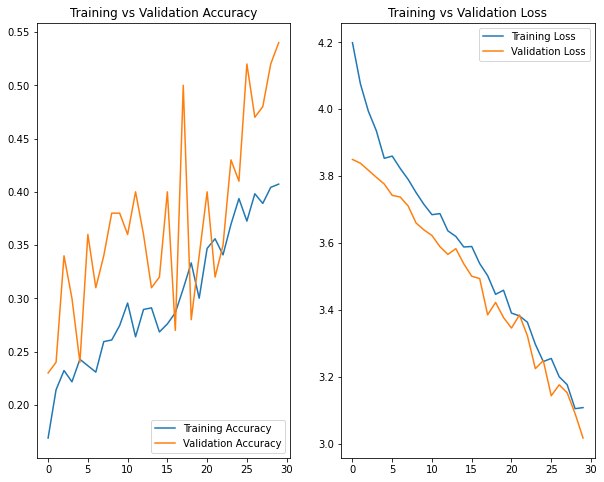

In [17]:
history = model_history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()

## Model 5: Conv3D with Adam optimizer and other parameter change

In [18]:
batch_size=30
num_epochs=40
image_x_shape = 160
image_y_shape = 160
random_set_seeds()

In [19]:
class convolution3D_withParameterChange():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        model = Sequential()
      
        model.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, image_x_shape, image_y_shape, 3)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01)))
        
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2),data_format='channels_first'))
        model.add(BatchNormalization())
        
       
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
        return model

In [20]:
obj = convolution3D_withParameterChange()
model = obj.model(batch_size)
optimiser = optimizers.Adam()

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 10, 160, 160, 8)   656       
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 5, 80, 80, 8)     0         
 3D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 5, 80, 80, 8)     32        
 hNormalization)                                                 
                                                                 
 conv3d_7 (Conv3D)           (None, 5, 80, 80, 16)     3472      
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 2, 40, 40, 16)    0         
 3D)                                                             
                                                      

In [22]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [23]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 2,
                             verbose = 1, mode = "auto", cooldown = 0)
callbacks_list = [checkpoint, LR]

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [25]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-25-e82077a6fcdf>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 30
Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 3.7326 - accuracy: 0.1765 Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-05-1013_27_23.908634/model-00001-3.73258-0.17647.h5
23/23 [==============================] - 339s 15s/step - loss: 3.7326 - accuracy: 0.1765 - val_loss: 2.7405 - val_accuracy: 0.2300 - lr: 0.0010
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 2.8103 - accuracy: 0.2323 
Epoch 2: saving model to model_init_2022-05-1013_27_23.908634/model-00002-2.81034-0.23228.h5
23/23 [==============================] - 331s 14s/step - loss: 2.8103 - accuracy: 0.2323 - val_loss: 2.6188 - val_accuracy: 0.2400 - lr: 0.0010
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 2.6882 - accuracy: 0.2232 
Epoch 3: saving model to model_init_2022-05-1013_27_23.908634/model-00003-2.68825-0.22323.h5
23/23 [==============================] - 335s 

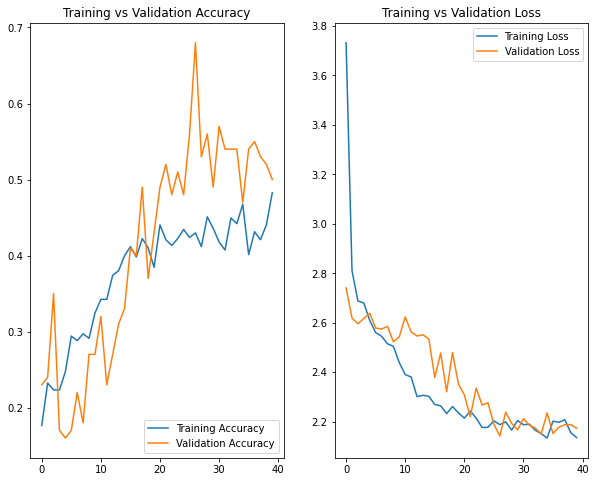

In [26]:
history = model_history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()

## Model 6: Convulational2D model with Adam optimizer and use GRU instead of LSTM to make it simpler

In [32]:
batch_size=30
num_epochs=40
image_x_shape = 160
image_y_shape = 160
random_set_seeds()

In [35]:
class Convolution2DWithGRU():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        cnn_model = Sequential()
        cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_x_shape, 3)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        cnn_model.add(Dropout(0.50))
        
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        
        cnn_model.add(TimeDistributed(Flatten()))
        
        cnn_model.add(Dense(64, activation='relu'))
        cnn_model.add(GRU(64, return_sequences=False))
        cnn_model.add(Dropout(.2))
        cnn_model.add(Dense(5, activation='softmax'))
        return cnn_model

In [36]:
obj = Convolution2DWithGRU()
model = obj.model(batch_size)
optimiser = optimizers.Adam()

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_105 (TimeD  (None, 10, 160, 160, 32)  128      
 istributed)                                                     
                                                                 
 time_distributed_106 (TimeD  (None, 10, 160, 160, 32)  0        
 istributed)                                                     
                                                                 
 time_distributed_107 (TimeD  (None, 10, 79, 79, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_108 (TimeD  (None, 10, 79, 79, 32)   128       
 istributed)                                                     
                                                                 
 time_distributed_109 (TimeD  (None, 10, 79, 79, 32)  

In [37]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [38]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [39]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-39-e82077a6fcdf>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 30
Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 4.6777 - accuracy: 0.2066 Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-05-1103_33_13.120849/model-00001-4.67768-0.20664.h5
23/23 [==============================] - 295s 13s/step - loss: 4.6777 - accuracy: 0.2066 - val_loss: 3.6040 - val_accuracy: 0.1500 - lr: 0.0010
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 3.2012 - accuracy: 0.1629 
Epoch 2: saving model to model_init_2022-05-1103_33_13.120849/model-00002-3.20124-0.16290.h5
23/23 [==============================] - 290s 13s/step - loss: 3.2012 - accuracy: 0.1629 - val_loss: 2.7048 - val_accuracy: 0.1900 - lr: 0.0010
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 2.4564 - accuracy: 0.1825 
Epoch 3: saving model to model_init_2022-05-1103_33_13.120849/model-00003-2.45638-0.18250.h5
23/23 [==============================] - 286s 

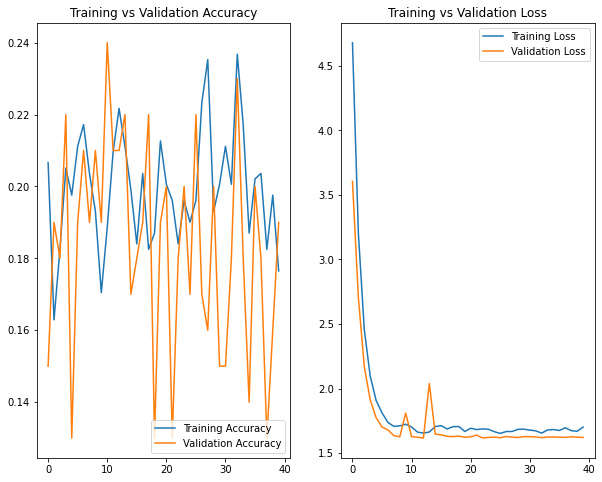

In [40]:
history = model_history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()